In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# coding: utf-8
# Author: C.J. Hutto
# Thanks to George Berry for reducing the time complexity from something like O(N^4) to O(N).
# Thanks to Ewan Klein and Pierpaolo Pantone for bringing VADER into NLTK. Those modifications were awesome.
# For license information, see LICENSE.TXT

"""
If you use the VADER sentiment analysis tools, please cite:
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""
import os
import re
import math
import string
import codecs
import json
from itertools import product
from inspect import getsourcefile
from io import open
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gunn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
import pandas as pd
df = pd.read_csv('clean_data_new_new_EHalf.csv')
print('Done')

Done


In [21]:
df

,dates,hour,minute,Text,text_remove_urls_numbers_punctuation_stopword
0,2021-07-17,0,51,Bullish Bitcoin Price Signal Starts ‘Pumping’ ...,Bullish Bitcoin Price Signal Starts Pumping BT...
1,2021-07-17,0,50,Opinion: #Bitcoin’s Impact On #ElSalvador’s Ge...,Opinion Bitcoins Impact On ElSalvadors Geopoli...
2,2021-07-17,0,50,@PrinceySOV Someone keep track of how much thi...,PrinceySOV Someone keep track much million wou...
3,2021-07-17,0,50,"📈💴$1,675,494 #bitcoin LONGED @$31405.12 [17/07...",bitcoin LONGED bybit BTCUSD Do even lift bro P...
4,2021-07-17,0,50,I love 🇸🇻 but not enough to get the 💉 \n\n@nay...,I love enough get nayibbukele many concerns he...
...,...,...,...,...,...
4579358,2022-02-04,0,0,"#Bitcoin is currently $37,304.8650",Bitcoin currently
4579359,2022-02-04,0,0,"【Our Logo】\n\nEveryone’s dreams, all kinds of ...",Our Logo Everyones dreams kinds dreams Taking ...
4579360,2022-02-04,0,0,"""Bitcoin may be the TCP/IP of money."" #bitcoin...",Bitcoin may TCPIP money bitcoin bunnies
4579361,2022-02-04,0,0,"Bitcoin - BTC\nPrice: $37,071.64\nChange in 1h...",Bitcoin BTC Price Change h Market cap Ranking ...


In [22]:
# ##Constants##

# (empirically derived mean sentiment intensity rating increase for booster words)
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using ALLCAPs to emphasize a word)
C_INCR = 0.733
N_SCALAR = -0.74

NEGATE = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
    {"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, 
     "completely": B_INCR, "considerable": B_INCR, "considerably": B_INCR,
     "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormous": B_INCR, "enormously": B_INCR,
     "entirely": B_INCR, "especially": B_INCR, "exceptional": B_INCR, "exceptionally": B_INCR, 
     "extreme": B_INCR, "extremely": B_INCR,
     "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR, "frackin": B_INCR, "fracking": B_INCR,
     "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, 
     "fuckin": B_INCR, "fucking": B_INCR, "fuggin": B_INCR, "fugging": B_INCR,
     "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, 
     "incredible": B_INCR, "incredibly": B_INCR, "intensely": B_INCR, 
     "major": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
     "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
     "so": B_INCR, "substantially": B_INCR,
     "thoroughly": B_INCR, "total": B_INCR, "totally": B_INCR, "tremendous": B_INCR, "tremendously": B_INCR,
     "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utter": B_INCR, "utterly": B_INCR,
     "very": B_INCR,
     "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
     "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
     "less": B_DECR, "little": B_DECR, "marginal": B_DECR, "marginally": B_DECR,
     "occasional": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
     "scarce": B_DECR, "scarcely": B_DECR, "slight": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
     "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}

# check for sentiment laden idioms that do not contain lexicon words (future work, not yet implemented)
SENTIMENT_LADEN_IDIOMS = {"cut the mustard": 2, "hand to mouth": -2,
                          "back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                          "upper hand": 1, "break a leg": 2,
                          "cooking with gas": 2, "in the black": 2, "in the red": -2,
                          "on the ball": 2, "under the weather": -2}

# check for special case idioms and phrases containing lexicon words
SPECIAL_CASES = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "badass": 1.5, "bus stop": 0.0,
                 "yeah right": -2, "kiss of death": -1.5, "to die for": 3, 
                 "beating heart": 3.1, "broken heart": -2.9 }

In [23]:
# #Static methods# #

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    input_words = [str(w).lower() for w in input_words]
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    '''if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i - 1] != "at":
            return True'''
    return False

In [24]:
def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score

In [25]:
def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if 0 < cap_differential < len(words):
        is_different = True
    return is_different

In [26]:
def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1
        # check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else:
                scalar -= C_INCR
    return scalar

In [27]:
class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text).encode('utf-8')
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from\
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)

    @staticmethod
    def _strip_punc_if_word(token):
        """
        Removes all trailing and leading punctuation
        If the resulting string has two or fewer characters,
        then it was likely an emoticon, so return original string
        (ie ":)" stripped would be "", so just return ":)"
        """
        stripped = token.strip(string.punctuation)
        if len(stripped) <= 2:
            return token
        return stripped

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        stripped = list(map(self._strip_punc_if_word, wes))
        return stripped

In [28]:
class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """

    def __init__(self, lexicon_file="vader_lexicon.txt", emoji_lexicon="emoji_utf8_lexicon.txt"):
        _this_module_file_path_ = os.path.abspath(getsourcefile(lambda: 0))
        lexicon_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), lexicon_file)
        with codecs.open(lexicon_full_filepath, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

        emoji_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), emoji_lexicon)
        with codecs.open(emoji_full_filepath, encoding='utf-8') as f:
            self.emoji_full_filepath = f.read()
        self.emojis = self.make_emoji_dict()

    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.rstrip('\n').split('\n'):
            if not line:
                continue
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict

    def make_emoji_dict(self):
        """
        Convert emoji lexicon file to a dictionary
        """
        emoji_dict = {}
        for line in self.emoji_full_filepath.rstrip('\n').split('\n'):
            (emoji, description) = line.strip().split('\t')[0:2]
            emoji_dict[emoji] = description
        return emoji_dict

    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """
        # convert emojis to their textual descriptions
        text_no_emoji = ""
        prev_space = True
        for chr in text:
            if chr in self.emojis:
                # get the textual description
                description = self.emojis[chr]
                if not prev_space:
                    text_no_emoji += ' '
                text_no_emoji += description
                prev_space = False
            else:
                text_no_emoji += chr
                prev_space = chr == ' '
        text = text_no_emoji.strip()

        sentitext = SentiText(text)

        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for i, item in enumerate(words_and_emoticons):
            valence = 0
            # check for vader_lexicon words that may be used as modifiers or negations
            if item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue
            if (i < len(words_and_emoticons) - 1 and item.lower() == "kind" and
                    words_and_emoticons[i + 1].lower() == "of"):
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)

        valence_dict = self.score_valence(sentiments, text)

        return valence_dict

    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            # get the sentiment valence 
            valence = self.lexicon[item_lowercase]
                
            # check for "no" as negation for an adjacent lexicon item vs "no" as its own stand-alone lexicon item
            if item_lowercase == "no" and i != len(words_and_emoticons)-1 and words_and_emoticons[i + 1].lower() in self.lexicon:
                # don't use valence of "no" as a lexicon item. Instead set it's valence to 0.0 and negate the next item
                valence = 0.0
            if (i > 0 and words_and_emoticons[i - 1].lower() == "no") \
               or (i > 1 and words_and_emoticons[i - 2].lower() == "no") \
               or (i > 2 and words_and_emoticons[i - 3].lower() == "no" and words_and_emoticons[i - 1].lower() in ["or", "nor"] ):
                valence = self.lexicon[item_lowercase] * N_SCALAR
            
            # check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR

            for start_i in range(0, 3):
                # dampen the scalar modifier of preceding words and emoticons
                # (excluding the ones that immediately preceed the item) based
                # on their distance from the current item.
                if i > start_i and words_and_emoticons[i - (start_i + 1)].lower() not in self.lexicon:
                    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._negation_check(valence, words_and_emoticons, start_i, i)
                    if start_i == 2:
                        valence = self._special_idioms_check(valence, words_and_emoticons, i)

            valence = self._least_check(valence, words_and_emoticons, i)
        sentiments.append(valence)
        return sentiments

    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if i > 1 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            if words_and_emoticons[i - 2].lower() != "at" and words_and_emoticons[i - 2].lower() != "very":
                valence = valence * N_SCALAR
        elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            valence = valence * N_SCALAR
        return valence

    @staticmethod
    def _but_check(words_and_emoticons, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if 'but' in words_and_emoticons_lower:
            bi = words_and_emoticons_lower.index('but')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 1.5)
        return sentiments

    @staticmethod
    def _special_idioms_check(valence, words_and_emoticons, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        onezero = "{0} {1}".format(words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoonezero = "{0} {1} {2}".format(words_and_emoticons_lower[i - 2],
                                          words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoone = "{0} {1}".format(words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwoone = "{0} {1} {2}".format(words_and_emoticons_lower[i - 3],
                                           words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwo = "{0} {1}".format(words_and_emoticons_lower[i - 3], words_and_emoticons_lower[i - 2])

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in SPECIAL_CASES:
                valence = SPECIAL_CASES[seq]
                break

        if len(words_and_emoticons_lower) - 1 > i:
            zeroone = "{0} {1}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1])
            if zeroone in SPECIAL_CASES:
                valence = SPECIAL_CASES[zeroone]
        if len(words_and_emoticons_lower) - 1 > i + 1:
            zeroonetwo = "{0} {1} {2}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1],
                                              words_and_emoticons_lower[i + 2])
            if zeroonetwo in SPECIAL_CASES:
                valence = SPECIAL_CASES[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        n_grams = [threetwoone, threetwo, twoone]
        for n_gram in n_grams:
            if n_gram in BOOSTER_DICT:
                valence = valence + BOOSTER_DICT[n_gram]
        return valence

    @staticmethod
    def _sentiment_laden_idioms_check(valence, senti_text_lower):
        # Future Work
        # check for sentiment laden idioms that don't contain a lexicon word
        idioms_valences = []
        for idiom in SENTIMENT_LADEN_IDIOMS:
            if idiom in senti_text_lower:
                print(idiom, senti_text_lower)
                valence = SENTIMENT_LADEN_IDIOMS[idiom]
                idioms_valences.append(valence)
        if len(idioms_valences) > 0:
            valence = sum(idioms_valences) / float(len(idioms_valences))
        return valence

    @staticmethod
    def _negation_check(valence, words_and_emoticons, start_i, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if start_i == 0:
            if negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 1 word preceding lexicon word (w/o stopwords)
                valence = valence * N_SCALAR
        if start_i == 1:
            if words_and_emoticons_lower[i - 2] == "never" and \
                    (words_and_emoticons_lower[i - 1] == "so" or
                     words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 2] == "without" and \
                    words_and_emoticons_lower[i - 1] == "doubt":
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 2 words preceding the lexicon word position
                valence = valence * N_SCALAR
        if start_i == 2:
            if words_and_emoticons_lower[i - 3] == "never" and \
                    (words_and_emoticons_lower[i - 2] == "so" or words_and_emoticons_lower[i - 2] == "this") or \
                    (words_and_emoticons_lower[i - 1] == "so" or words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 3] == "without" and \
                    (words_and_emoticons_lower[i - 2] == "doubt" or words_and_emoticons_lower[i - 1] == "doubt"):
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 3 words preceding the lexicon word position
                valence = valence * N_SCALAR
        return valence

    def _punctuation_emphasis(self, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier
        return punct_emph_amplifier

    @staticmethod
    def _amplify_ep(text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count * 0.292
        return ep_amplifier

    @staticmethod
    def _amplify_qm(text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    @staticmethod
    def _sift_sentiment_scores(sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) + 1)  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) - 1)  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg": round(neg, 3),
             "neu": round(neu, 3),
             "pos": round(pos, 3),
             "compound": round(compound, 4)}

        return sentiment_dict

In [29]:
from nltk import tokenize


def compute_vadar_score_avg(paragraph):
  total_list =[]
  analyzer = SentimentIntensityAnalyzer()

  sentence_list = tokenize.sent_tokenize(str(paragraph))
  paragraphSentiments = 0.0

  for sentence in sentence_list:
      
      vs = analyzer.polarity_scores(sentence)
      # print("{:-<69} {}".format(sentence, str(vs["compound"])))
      paragraphSentiments += vs["compound"]

      # print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments / len(sentence_list), 4)))
      # print("----------------------------------------------------")
    
      AVG_SENTIMENT = round(paragraphSentiments / len(sentence_list), 4)
      # print(AVG_SENTIMENT)
  return list(vs.values())


In [30]:
import os

In [31]:
df["text_remove_urls_numbers_punctuation_stopword"] = df["text_remove_urls_numbers_punctuation_stopword"].apply(compute_vadar_score_avg)


In [32]:
df

,dates,hour,minute,Text,text_remove_urls_numbers_punctuation_stopword
0,2021-07-17,0,51,Bullish Bitcoin Price Signal Starts ‘Pumping’ ...,"[0.0, 1.0, 0.0, 0.0]"
1,2021-07-17,0,50,Opinion: #Bitcoin’s Impact On #ElSalvador’s Ge...,"[0.0, 1.0, 0.0, 0.0]"
2,2021-07-17,0,50,@PrinceySOV Someone keep track of how much thi...,"[0.0, 1.0, 0.0, 0.0]"
3,2021-07-17,0,50,"📈💴$1,675,494 #bitcoin LONGED @$31405.12 [17/07...","[0.0, 1.0, 0.0, 0.0]"
4,2021-07-17,0,50,I love 🇸🇻 but not enough to get the 💉 \n\n@nay...,"[0.205, 0.431, 0.364, 0.699]"
...,...,...,...,...,...
4579358,2022-02-04,0,0,"#Bitcoin is currently $37,304.8650","[0.0, 1.0, 0.0, 0.0]"
4579359,2022-02-04,0,0,"【Our Logo】\n\nEveryone’s dreams, all kinds of ...","[0.0, 0.627, 0.373, 0.8176]"
4579360,2022-02-04,0,0,"""Bitcoin may be the TCP/IP of money."" #bitcoin...","[0.0, 1.0, 0.0, 0.0]"
4579361,2022-02-04,0,0,"Bitcoin - BTC\nPrice: $37,071.64\nChange in 1h...","[0.0, 1.0, 0.0, 0.0]"


In [33]:
df[['neg','neu','pos','compound']] = pd.DataFrame(df.text_remove_urls_numbers_punctuation_stopword.tolist(), index= df.index)

In [34]:
# df["Vadar_clean_Link"] = df["cleanLinks"].apply(compute_vadar_score_avg)

In [35]:
df

,dates,hour,minute,Text,text_remove_urls_numbers_punctuation_stopword,neg,neu,pos,compound
0,2021-07-17,0,51,Bullish Bitcoin Price Signal Starts ‘Pumping’ ...,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
1,2021-07-17,0,50,Opinion: #Bitcoin’s Impact On #ElSalvador’s Ge...,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
2,2021-07-17,0,50,@PrinceySOV Someone keep track of how much thi...,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
3,2021-07-17,0,50,"📈💴$1,675,494 #bitcoin LONGED @$31405.12 [17/07...","[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
4,2021-07-17,0,50,I love 🇸🇻 but not enough to get the 💉 \n\n@nay...,"[0.205, 0.431, 0.364, 0.699]",0.205,0.431,0.364,0.6990
...,...,...,...,...,...,...,...,...,...
4579358,2022-02-04,0,0,"#Bitcoin is currently $37,304.8650","[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
4579359,2022-02-04,0,0,"【Our Logo】\n\nEveryone’s dreams, all kinds of ...","[0.0, 0.627, 0.373, 0.8176]",0.000,0.627,0.373,0.8176
4579360,2022-02-04,0,0,"""Bitcoin may be the TCP/IP of money."" #bitcoin...","[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
4579361,2022-02-04,0,0,"Bitcoin - BTC\nPrice: $37,071.64\nChange in 1h...","[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000


In [36]:
# saving the dataframe
df.to_csv('vader_text_remove_punctuation_urls_stopword_0.csv', header=True, index=False)

In [64]:
import pandas as pd
vader_score_clean_charecter_neg_neu_pos_compound = pd.read_csv('vader_score_clean_charecter_neg_neu_pos_compound.csv')
print('Done')

Done


In [65]:
vader_score_clean_charecter_neg_neu_pos_compound

,date,date_only,text,cleanLinks,clean_charecter,clean_tagename,Vadar_clean_charecter,neg,neu,pos,compound
0,2021-02-10 23:59:04,2021-02-10,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after bi...,blue ridge bank shares halted by nyse after a...,"[0.0, 0.82, 0.18, 0.296]",0.0,0.820,0.180,0.2960
1,2021-02-10 23:58:48,2021-02-10,"😎 today, that's this #thursday, we will do a ""...","😎 today, that's this #thursday, we will do a ""...","😎 today, that's this thursday, we will do a ""🎬...","😎 today, that's this , we will do a ""🎬 take 2""...","[0.0, 0.719, 0.281, 0.8225]",0.0,0.719,0.281,0.8225
2,2021-02-10 23:54:48,2021-02-10,"guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...","[0.0, 0.773, 0.227, 0.5719]",0.0,0.773,0.227,0.5719
3,2021-02-10 23:54:33,2021-02-10,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
4,2021-02-10 23:54:06,2021-02-10,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2259633,2022-01-19 19:08:16,2022-01-19,"#btc even broke the $42,000 support. a clear b...","#btc even broke the $42,000 support. a clear b...","btc even broke the $42,000 support. a clear br...","even broke the $42,000 support. a clear break...","[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
2259634,2022-01-19 19:08:08,2022-01-19,@ethfantoken we eating dips like no other ever...,@ethfantoken we eating dips like no other ever...,ethfantoken we eating dips like no other ever ...,ethfantoken we eating dips like no other ever ...,"[0.0, 0.82, 0.18, 0.296]",0.0,0.820,0.180,0.2960
2259635,2022-01-19 19:08:02,2022-01-19,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
2259636,2022-01-19 19:07:54,2022-01-19,wake me when it's over. #crypto #btc #ethereum,wake me when it's over. #crypto #btc #ethereum,wake me when it's over. crypto btc ethereum,wake me when it's over.,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000


In [67]:
select_column = vader_score_clean_charecter_neg_neu_pos_compound[['date_only','neg','neu','pos','compound']]

In [68]:
select_column

,date_only,neg,neu,pos,compound
0,2021-02-10,0.0,0.820,0.180,0.2960
1,2021-02-10,0.0,0.719,0.281,0.8225
2,2021-02-10,0.0,0.773,0.227,0.5719
3,2021-02-10,0.0,1.000,0.000,0.0000
4,2021-02-10,0.0,1.000,0.000,0.0000
...,...,...,...,...,...
2259633,2022-01-19,0.0,1.000,0.000,0.0000
2259634,2022-01-19,0.0,0.820,0.180,0.2960
2259635,2022-01-19,0.0,1.000,0.000,0.0000
2259636,2022-01-19,0.0,1.000,0.000,0.0000


In [69]:
groupBy_date = select_column.groupby('date_only').mean()

In [72]:
groupBy_date = groupBy_date.rename({'neg': 'Avg_neg', 'neu': 'Avg_neu', 'pos': 'Avg_pos', 'compound': 'Avg_compound'}, axis=1) 

In [73]:
groupBy_date

,Avg_neg,Avg_neu,Avg_pos,Avg_compound
date_only,,,,
2021-02-05,0.031965,0.899208,0.068829,0.077819
2021-02-06,0.030861,0.899653,0.069483,0.081142
2021-02-07,0.031418,0.888138,0.080446,0.094217
2021-02-08,0.027987,0.890526,0.081491,0.110987
2021-02-09,0.027811,0.898904,0.073295,0.101468
...,...,...,...,...
2022-01-14,0.032376,0.877630,0.089983,0.141087
2022-01-19,0.034410,0.891321,0.074261,0.100847
2022-01-20,0.033724,0.884413,0.081853,0.126188


## Find valumn Twitter By days

In [77]:
twitter_volumn = df.groupby('date_only').size()

In [81]:
df_twitter_volumn = twitter_volumn.to_frame()
df_twitter_volumn = df_twitter_volumn.rename(columns = {0:'Volumn'})

In [82]:
df_twitter_volumn.head()

,Volumn
date_only,
2021-02-05,1694
2021-02-06,3278
2021-02-07,3030
2021-02-08,5647
2021-02-09,4350


## Merge groupBy_date and df_twitter_volumn

In [83]:
result = pd.merge(groupBy_date,df_twitter_volumn[['Volumn']],on = 'date_only')

In [84]:
result

,Avg_neg,Avg_neu,Avg_pos,Avg_compound,Volumn
date_only,,,,,
2021-02-05,0.031965,0.899208,0.068829,0.077819,1694
2021-02-06,0.030861,0.899653,0.069483,0.081142,3278
2021-02-07,0.031418,0.888138,0.080446,0.094217,3030
2021-02-08,0.027987,0.890526,0.081491,0.110987,5647
2021-02-09,0.027811,0.898904,0.073295,0.101468,4350
...,...,...,...,...,...
2022-01-14,0.032376,0.877630,0.089983,0.141087,30041
2022-01-19,0.034410,0.891321,0.074261,0.100847,3674
2022-01-20,0.033724,0.884413,0.081853,0.126188,22074


In [88]:
# saving the dataframe
result.to_csv('vader_score_clean_charecter_meam.csv', header=True, index=True)

In [40]:
def Check_positive_negative(Vader_score):
    text=''
    
    if Vader_score < -0.25:
        text = 'Negative'
    elif Vader_score >= -0.25 and Vader_score <= 0.25:
        text = 'Neutral'
    else:
        text = 'Positive'
    return text

In [45]:
groupBy_date["Vadar_clean_charecter_Analysis"] = groupBy_date["Vadar_clean_charecter"].apply(Check_positive_negative)

<AxesSubplot:>

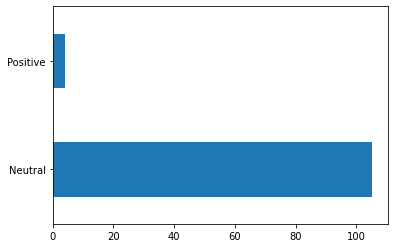

In [46]:
# importing the required module
import matplotlib.pyplot as plt
groupBy_date['Vadar_clean_charecter_Analysis'].value_counts().plot(kind='barh')

In [27]:
test_df = df.loc[0:100]

In [31]:
for i,j  in enumerate( df['date']):
  
  if 'a' in str(j):
    print(i)

In [43]:
test_df

,date,date_only,text,cleanLinks,clean_charecter,clean_tagename,Vadar_clean_charecter,Vadar_clean_charecter_Analysis
0,2021-02-10 23:59:04,2021-02-10,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after bi...,blue ridge bank shares halted by nyse after a...,0.2960,Positive
1,2021-02-10 23:58:48,2021-02-10,"😎 today, that's this #thursday, we will do a ""...","😎 today, that's this #thursday, we will do a ""...","😎 today, that's this thursday, we will do a ""🎬...","😎 today, that's this , we will do a ""🎬 take 2""...",0.8225,Positive
2,2021-02-10 23:54:48,2021-02-10,"guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...",0.5719,Positive
3,2021-02-10 23:54:33,2021-02-10,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,0.1582,Neutral
4,2021-02-10 23:54:06,2021-02-10,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,0.2009,Neutral
...,...,...,...,...,...,...,...,...
96,2021-02-10 23:09:59,2021-02-10,"@michael_saylor advertising tactic called ""lin...","@michael_saylor advertising tactic called ""lin...","michael_saylor advertising tactic called ""link...","michael_saylor advertising tactic called ""link...",0.0000,Neutral
97,2021-02-10 23:09:39,2021-02-10,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,-0.2023,Neutral
98,2021-02-10 23:09:18,2021-02-10,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,-0.2287,Neutral
99,2021-02-10 23:08:14,2021-02-10,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,0.3890,Positive


In [15]:
test_df["Vadar_clean_charecter"] = test_df["clean_charecter"].apply(compute_vadar_score_avg)
test_df["Vadar_clean_tagename"] = test_df["clean_tagename"].apply(compute_vadar_score_avg)

C:\Users\Gunn\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Gunn\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
test_df

,date,date_only,text,cleanLinks,clean_charecter,clean_tagename,Vadar_clean_charecter,Vadar_clean_tagename
0,2021-02-10 23:59:04,2021-02-10,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after bi...,blue ridge bank shares halted by nyse after a...,0.2960,0.2960
1,2021-02-10 23:58:48,2021-02-10,"😎 today, that's this #thursday, we will do a ""...","😎 today, that's this #thursday, we will do a ""...","😎 today, that's this thursday, we will do a ""🎬...","😎 today, that's this , we will do a ""🎬 take 2""...",0.8225,0.7351
2,2021-02-10 23:54:48,2021-02-10,"guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...",0.5719,0.5719
3,2021-02-10 23:54:33,2021-02-10,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,0.1582,0.1582
4,2021-02-10 23:54:06,2021-02-10,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,0.2009,0.2009
...,...,...,...,...,...,...,...,...
96,2021-02-10 23:09:59,2021-02-10,"@michael_saylor advertising tactic called ""lin...","@michael_saylor advertising tactic called ""lin...","michael_saylor advertising tactic called ""link...","michael_saylor advertising tactic called ""link...",0.0000,0.0000
97,2021-02-10 23:09:39,2021-02-10,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,🔄 prices update in $usd (1 hour):\n\n$btc - ...,-0.2023,-0.2023
98,2021-02-10 23:09:18,2021-02-10,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,just added episode 25 - insane 888eth ($1.5m) ...,-0.2287,-0.2287
99,2021-02-10 23:08:14,2021-02-10,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,$ftm is looking super amazing. should easily d...,0.3890,0.3890


In [ ]:
df[["Vadar_clean_charecter", "Vadar_clean_tagename"]] = df[["clean_charecter", "clean_tagename"]].apply(compute_vadar_score_avg,axis=1)

KeyboardInterrupt: ignored

In [ ]:
df

,date,date_only,text,cleanLinks,clean_charecter,clean_tagename,Vadar_clean_charecter,Vadar_clean_tagename
0,2021-02-10 23:59:04,2021-02-10,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after #b...,blue ridge bank shares halted by nyse after bi...,blue ridge bank shares halted by nyse after a...,0.3414,0.3734
1,2021-02-10 23:58:48,2021-02-10,"😎 today, that's this #thursday, we will do a ""...","😎 today, that's this #thursday, we will do a ""...","😎 today, that's this thursday, we will do a ""🎬...","😎 today, that's this , we will do a ""🎬 take 2""...",0.3414,0.3734
2,2021-02-10 23:54:48,2021-02-10,"guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...","guys evening, i have read this article about b...",0.3414,0.3734
3,2021-02-10 23:54:33,2021-02-10,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,$btc a big chance in a billion! price: \487264...,0.3414,0.3734
4,2021-02-10 23:54:06,2021-02-10,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,this network is secured by 9 508 nodes as of t...,0.3414,0.3734
...,...,...,...,...,...,...,...,...
2950382,2022-01-19 19:08:16,2022-01-19,"#btc even broke the $42,000 support. a clear b...","#btc even broke the $42,000 support. a clear b...","btc even broke the $42,000 support. a clear br...","even broke the $42,000 support. a clear break...",0.3414,0.3734
2950383,2022-01-19 19:08:08,2022-01-19,@ethfantoken we eating dips like no other ever...,@ethfantoken we eating dips like no other ever...,ethfantoken we eating dips like no other ever ...,ethfantoken we eating dips like no other ever ...,0.3414,0.3734
2950384,2022-01-19 19:08:02,2022-01-19,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,the agitation at these price levels is unwarra...,0.3414,0.3734
2950385,2022-01-19 19:07:54,2022-01-19,wake me when it's over. #crypto #btc #ethereum,wake me when it's over. #crypto #btc #ethereum,wake me when it's over. crypto btc ethereum,wake me when it's over.,0.3414,0.3734


In [ ]:
from nltk import tokenize

total_list =[]
analyzer = SentimentIntensityAnalyzer()
for i,paragraph in enumerate(df['clean_tagename']):
  temp_list = []
  # paragraph=Total_list[i][1]
  sentence_list = tokenize.sent_tokenize(str(paragraph))
  paragraphSentiments = 0.0

  
  for sentence in sentence_list:
    
      vs = analyzer.polarity_scores(sentence)
      # print("{:-<69} {}".format(sentence, str(vs["compound"])))
      paragraphSentiments += vs["compound"]

      # print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments / len(sentence_list), 4)))
      # print("----------------------------------------------------")
    
      AVG_SENTIMENT = round(paragraphSentiments / len(sentence_list), 4)
      # print(AVG_SENTIMENT)
  # temp_list.append(paragraph)
  temp_list.append(AVG_SENTIMENT)
  total_list.append(temp_list)
  print(i, end = "\r")
      # print(total_list)


KeyboardInterrupt: ignored

In [ ]:
Df_Vadar_sentiment = pd.DataFrame(total_list, columns =['vader_score_clean_tagename_mergeDay'])

NameError: ignored

In [ ]:
Df_Vadar_sentiment

,vader_score_clean_tagename
0,0.2960
1,0.7351
2,0.5719
3,0.1582
4,0.2009
...,...
2950382,0.2200
2950383,0.3411
2950384,-0.1091
2950385,0.0000


In [ ]:
result = pd.concat([file2, Df_Vadar_sentiment], axis=1)

In [ ]:
result

,date_only,text,cleanLinks,clean_charecter,clean_tagename,vader_score_clean_tagename
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank shares halted by NYSE after bi...,Blue Ridge Bank shares halted by NYSE after A...,0.2960
1,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...","😎 Today, that's this #Thursday, we will do a ""...","😎 Today, that's this Thursday, we will do a ""🎬...","😎 Today, that's this , we will do a ""🎬 Take 2""...",0.7351
2,2021-02-10,"Guys evening, I have read this article about B...","Guys evening, I have read this article about B...","Guys evening, I have read this article about B...","Guys evening, I have read this article about B...",0.5719
3,2021-02-10,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,0.1582
4,2021-02-10,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,0.2009
...,...,...,...,...,...,...
2950382,2022-01-19,"#BTC even broke the $42,000 support. A clear b...","#BTC even broke the $42,000 support. A clear b...","BTC even broke the $42,000 support. A clear br...","even broke the $42,000 support. A clear break...",0.2200
2950383,2022-01-19,@ETHFanToken we eating dips like no other ever...,@ETHFanToken we eating dips like no other ever...,ETHFanToken we eating dips like no other ever ...,ETHFanToken we eating dips like no other ever ...,0.3411
2950384,2022-01-19,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,-0.1091
2950385,2022-01-19,Wake me when it's over. #Crypto #btc #Ethereum,Wake me when it's over. #Crypto #btc #Ethereum,Wake me when it's over. Crypto btc Ethereum,Wake me when it's over.,0.0000


In [ ]:
# saving the dataframe
result.to_csv('vader_score_clean_tagename.csv', header=True, index=False)

In [ ]:
from nltk import tokenize

total_list =[]
analyzer = SentimentIntensityAnalyzer()
for i,paragraph in enumerate(col_to_list):
  temp_list = []
  sentence_list = tokenize.sent_tokenize(str(paragraph))
  paragraphSentiments = 0.0

  if i <500:
    for sentence in sentence_list:
      
        vs = analyzer.polarity_scores(sentence)
        # print("{:-<69} {}".format(sentence, str(vs["compound"])))
        paragraphSentiments += vs["compound"]

        # print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments / len(sentence_list), 4)))
        # print("----------------------------------------------------")
      
        AVG_SENTIMENT = round(paragraphSentiments / len(sentence_list), 4)
        # print(AVG_SENTIMENT)
    temp_list.append(paragraph)
    temp_list.append(AVG_SENTIMENT)
    total_list.append(temp_list)
    print(i, end = "\r")
  
  else:
    break
      # print(total_list)


In [ ]:
def FindMaxLength(lst):
    maxList = max(lst, key = len)
    maxLength = max(map(len, lst))
      
    return maxList, maxLength

In [ ]:
print(FindMaxLength(total_list))

(['Blue Ridge Bank shares halted by NYSE after bitcoin ATM announcement ', 0.296], 2)


In [ ]:
# saving the dataframe
Df_Vadar_sentiment.to_csv('Vadar_Sentiment.csv', header=True, index=False)

In [ ]:
test_file = pd.read_csv('/content/Vadar_Sentiment.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_file

,real_text,vader_score
0,Blue Ridge Bank shares halted by NYSE after bi...,0.2960
1,"😎 Today, that's this Thursday, we will do a ""🎬...",0.8225
2,"Guys evening, I have read this article about B...",0.5719
3,$BTC A big chance in a billion! Price: \487264...,0.1582
4,This network is secured by 9 508 nodes as of t...,0.2009
...,...,...
2950382,"BTC even broke the $42,000 support. A clear br...",0.2200
2950383,ETHFanToken we eating dips like no other ever ...,0.4397
2950384,The agitation at these price levels is unwarra...,-0.1091
2950385,Wake me when it's over. Crypto btc Ethereum,0.0000


In [ ]:
2950387

In [ ]:
result = pd.concat([file2, test_file], axis=1)

In [ ]:
result

,date_only,text,cleanLinks,clean_charecter,clean_tagename,real_text,vader_score
0,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank shares halted by NYSE after #b...,Blue Ridge Bank shares halted by NYSE after bi...,Blue Ridge Bank shares halted by NYSE after A...,Blue Ridge Bank shares halted by NYSE after bi...,0.2960
1,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...","😎 Today, that's this #Thursday, we will do a ""...","😎 Today, that's this Thursday, we will do a ""🎬...","😎 Today, that's this , we will do a ""🎬 Take 2""...","😎 Today, that's this Thursday, we will do a ""🎬...",0.8225
2,2021-02-10,"Guys evening, I have read this article about B...","Guys evening, I have read this article about B...","Guys evening, I have read this article about B...","Guys evening, I have read this article about B...","Guys evening, I have read this article about B...",0.5719
3,2021-02-10,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,$BTC A big chance in a billion! Price: \487264...,0.1582
4,2021-02-10,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,This network is secured by 9 508 nodes as of t...,0.2009
...,...,...,...,...,...,...,...
2950382,2022-01-19,"#BTC even broke the $42,000 support. A clear b...","#BTC even broke the $42,000 support. A clear b...","BTC even broke the $42,000 support. A clear br...","even broke the $42,000 support. A clear break...","BTC even broke the $42,000 support. A clear br...",0.2200
2950383,2022-01-19,@ETHFanToken we eating dips like no other ever...,@ETHFanToken we eating dips like no other ever...,ETHFanToken we eating dips like no other ever ...,ETHFanToken we eating dips like no other ever ...,ETHFanToken we eating dips like no other ever ...,0.4397
2950384,2022-01-19,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,The agitation at these price levels is unwarra...,-0.1091
2950385,2022-01-19,Wake me when it's over. #Crypto #btc #Ethereum,Wake me when it's over. #Crypto #btc #Ethereum,Wake me when it's over. Crypto btc Ethereum,Wake me when it's over.,Wake me when it's over. Crypto btc Ethereum,0.0000


In [ ]:
# saving the dataframe
result.to_csv('merge_table.csv', header=True, index=False)

In [ ]:
len(col_to_list)

2950387

In [ ]:
if __name__ == '__main__':
    # --- examples -------
    sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
                 "VADER is smart, handsome, and funny!",
                 # punctuation emphasis handled correctly (sentiment intensity adjusted)
                 "VADER is very smart, handsome, and funny.",
                 # booster words handled correctly (sentiment intensity adjusted)
                 "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
                 "VADER is VERY SMART, handsome, and FUNNY!!!",
                 # combination of signals - VADER appropriately adjusts intensity
                 "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!",
                 # booster words & punctuation make this close to ceiling for score
                 "VADER is not smart, handsome, nor funny.",  # negation sentence example
                 "The book was good.",  # positive sentence
                 "At least it isn't a horrible book.",  # negated negative sentence with contraction
                 "The book was only kind of good.",
                 # qualified positive sentence is handled correctly (intensity adjusted)
                 "The plot was good, but the characters are uncompelling and the dialog is not great.",
                 # mixed negation sentence
                 "Today SUX!",  # negative slang with capitalization emphasis
                 "Today only kinda sux! But I'll get by, lol",
                 # mixed sentiment example with slang and constrastive conjunction "but"
                 "Make sure you :) or :D today!",  # emoticons handled
                 "Catch utf-8 emoji such as 💘 and 💋 and 😁",  # emojis handled
                 "Not bad at all"  # Capitalized negation
                 ]

    analyzer = SentimentIntensityAnalyzer()

    print("----------------------------------------------------")
    print(" - Analyze typical example cases, including handling of:")
    print("  -- negations")
    print("  -- punctuation emphasis & punctuation flooding")
    print("  -- word-shape as emphasis (capitalization difference)")
    print("  -- degree modifiers (intensifiers such as 'very' and dampeners such as 'kind of')")
    print("  -- slang words as modifiers such as 'uber' or 'friggin' or 'kinda'")
    print("  -- contrastive conjunction 'but' indicating a shift in sentiment; sentiment of later text is dominant")
    print("  -- use of contractions as negations")
    print("  -- sentiment laden emoticons such as :) and :D")
    print("  -- utf-8 encoded emojis such as 💘 and 💋 and 😁")
    print("  -- sentiment laden slang words (e.g., 'sux')")
    print("  -- sentiment laden initialisms and acronyms (for example: 'lol') \n")
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        print("{:-<65} {}".format(sentence, str(vs)))
    print("----------------------------------------------------")
    print(" - About the scoring: ")
    print("""  -- The 'compound' score is computed by summing the valence scores of each word in the lexicon, adjusted
     according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).
     This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence.
     Calling it a 'normalized, weighted composite score' is accurate.""")
    print("""  -- The 'pos', 'neu', and 'neg' scores are ratios for proportions of text that fall in each category (so these
     should all add up to be 1... or close to it with float operation).  These are the most useful metrics if
     you want multidimensional measures of sentiment for a given sentence.""")
    print("----------------------------------------------------")

    # input("\nPress Enter to continue the demo...\n")  # for DEMO purposes...

    tricky_sentences = ["Sentiment analysis has never been good.",
                        "Sentiment analysis has never been this good!",
                        "Most automated sentiment analysis tools are shit.",
                        "With VADER, sentiment analysis is the shit!",
                        "Other sentiment analysis tools can be quite bad.",
                        "On the other hand, VADER is quite bad ass",
                        "VADER is such a badass!",  # slang with punctuation emphasis
                        "Without a doubt, excellent idea.",
                        "Roger Dodger is one of the most compelling variations on this theme.",
                        "Roger Dodger is at least compelling as a variation on the theme.",
                        "Roger Dodger is one of the least compelling variations on this theme.",
                        "Not such a badass after all.",  # Capitalized negation with slang
                        "Without a doubt, an excellent idea."  # "without {any} doubt" as negation
                        ]
    print("----------------------------------------------------")
    print(" - Analyze examples of tricky sentences that cause trouble to other sentiment analysis tools.")
    print("  -- special case idioms - e.g., 'never good' vs 'never this good', or 'bad' vs 'bad ass'.")
    print("  -- special uses of 'least' as negation versus comparison \n")
    for sentence in tricky_sentences:
        vs = analyzer.polarity_scores(sentence)
        print("{:-<69} {}".format(sentence, str(vs)))
    print("----------------------------------------------------")

    # input("\nPress Enter to continue the demo...\n")  # for DEMO purposes...

    print("----------------------------------------------------")
    print(
        " - VADER works best when analysis is done at the sentence level (but it can work on single words or entire novels).")
    paragraph = "It was one of the worst movies I've seen, despite good reviews. Unbelievably bad acting!! Poor direction. VERY poor production. The movie was bad. Very bad movie. VERY BAD movie!"
    print("  -- For example, given the following paragraph text from a hypothetical movie review:\n\t'{}'".format(
        paragraph))
    print(
        "  -- You could use NLTK to break the paragraph into sentence tokens for VADER, then average the results for the paragraph like this: \n")
    # simple example to tokenize paragraph into sentences for VADER
    from nltk import tokenize

    sentence_list = tokenize.sent_tokenize(paragraph)
    paragraphSentiments = 0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        print("{:-<69} {}".format(sentence, str(vs["compound"])))
        paragraphSentiments += vs["compound"]
    print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments / len(sentence_list), 4)))
    print("----------------------------------------------------")

    # input("\nPress Enter to continue the demo...\n")  # for DEMO purposes...

    print("----------------------------------------------------")
    print(" - Analyze sentiment of IMAGES/VIDEO data based on annotation 'tags' or image labels. \n")
    conceptList = ["balloons", "cake", "candles", "happy birthday", "friends", "laughing", "smiling", "party"]
    conceptSentiments = 0.0
    for concept in conceptList:
        vs = analyzer.polarity_scores(concept)
        print("{:-<15} {}".format(concept, str(vs['compound'])))
        conceptSentiments += vs["compound"]
    print("AVERAGE SENTIMENT OF TAGS/LABELS: \t" + str(round(conceptSentiments / len(conceptList), 4)))
    print("\t")
    conceptList = ["riot", "fire", "fight", "blood", "mob", "war", "police", "tear gas"]
    conceptSentiments = 0.0
    for concept in conceptList:
        vs = analyzer.polarity_scores(concept)
        print("{:-<15} {}".format(concept, str(vs['compound'])))
        conceptSentiments += vs["compound"]
    print("AVERAGE SENTIMENT OF TAGS/LABELS: \t" + str(round(conceptSentiments / len(conceptList), 4)))
    print("----------------------------------------------------")

    # input("\nPress Enter to continue the demo...")  # for DEMO purposes...

    do_translate = input(
        "\nWould you like to run VADER demo examples with NON-ENGLISH text? \n (Note: requires Internet access and uses the 'requests' library) \n Type 'y' or 'n', then press Enter: ")
    if do_translate.lower().lstrip().__contains__("y"):
        import requests
        print("\n----------------------------------------------------")
        print(" - Analyze sentiment of NON ENGLISH text...for example:")
        print("  -- French, German, Spanish, Italian, Russian, Japanese, Arabic, Chinese(Simplified) , Chinese(Traditional)")
        print("  -- many other languages supported. \n")
        languages = ["English", "French", "German", "Spanish", "Italian", "Russian", "Japanese", "Arabic", "Chinese(Simplified)", "Chinese(Traditional)"]
        language_codes = ["en", "fr", "de", "es", "it", "ru", "ja", "ar", "zh-CN", "zh-TW"]
        nonEnglish_sentences = ["I'm surprised to see just how amazingly helpful VADER is!",
                                "Je suis surpris de voir comment VADER est incroyablement utile !",
                                "Ich bin überrascht zu sehen, nur wie erstaunlich nützlich VADER!",
                                "Me sorprende ver sólo cómo increíblemente útil VADER!",
                                "Sono sorpreso di vedere solo come incredibilmente utile VADER è!",
                                "Я удивлен увидеть, как раз как удивительно полезно ВЕЙДЕРА!",
                                "私はちょうどどのように驚くほど役に立つベイダーを見て驚いています!",
                                "أنا مندهش لرؤية فقط كيف مثير للدهشة فيدر فائدة!",
                                "我很惊讶地看到VADER是如此有用!",
                                "我很驚訝地看到VADER是如此有用!"
                                ]
        for sentence in nonEnglish_sentences:
            to_lang = "en"
            from_lang = language_codes[nonEnglish_sentences.index(sentence)]
            if (from_lang == "en") or (from_lang == "en-US"):
                translation = sentence
                translator_name = "No translation needed"
            else:  # please note usage limits for My Memory Translation Service:   http://mymemory.translated.net/doc/usagelimits.php
                # using   MY MEMORY NET   http://mymemory.translated.net
                api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(sentence, from_lang,
                                                                                              to_lang)
                hdrs = {
                    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
                    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                    'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                    'Accept-Encoding': 'none',
                    'Accept-Language': 'en-US,en;q=0.8',
                    'Connection': 'keep-alive'}
                response = requests.get(api_url, headers=hdrs)
                response_json = json.loads(response.text)
                translation = response_json["responseData"]["translatedText"]
                translator_name = "MemoryNet Translation Service"
            vs = analyzer.polarity_scores(translation)
            print("- {: <8}: {: <69}\t {} ({})".format(languages[nonEnglish_sentences.index(sentence)], sentence,
                                                       str(vs['compound']), translator_name))
        print("----------------------------------------------------")

    print("\n\n Demo Done!")


----------------------------------------------------
 - Analyze typical example cases, including handling of:
  -- negations
  -- punctuation emphasis & punctuation flooding
  -- word-shape as emphasis (capitalization difference)
  -- degree modifiers (intensifiers such as 'very' and dampeners such as 'kind of')
  -- slang words as modifiers such as 'uber' or 'friggin' or 'kinda'
  -- contrastive conjunction 'but' indicating a shift in sentiment; sentiment of later text is dominant
  -- use of contractions as negations
  -- sentiment laden emoticons such as :) and :D
  -- utf-8 encoded emojis such as 💘 and 💋 and 😁
  -- sentiment laden slang words (e.g., 'sux')
  -- sentiment laden initialisms and acronyms (for example: 'lol') 

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is

In [ ]:
paragraph = "It was one of the worst movies I've seen, despite good reviews. Unbelievably bad acting!! Poor direction. VERY poor production. The movie was bad. Very bad movie. VERY BAD movie!"
print("  -- For example, given the following paragraph text from a hypothetical movie review:\n\t'{}'".format(
    paragraph))
print(
    "  -- You could use NLTK to break the paragraph into sentence tokens for VADER, then average the results for the paragraph like this: \n")
# simple example to tokenize paragraph into sentences for VADER
from nltk import tokenize

sentence_list = tokenize.sent_tokenize(paragraph)
paragraphSentiments = 0.0
for sentence in sentence_list:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<69} {}".format(sentence, str(vs["compound"])))
    paragraphSentiments += vs["compound"]
print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(round(paragraphSentiments / len(sentence_list), 4)))
print("----------------------------------------------------")

  -- For example, given the following paragraph text from a hypothetical movie review:
	'It was one of the worst movies I've seen, despite good reviews. Unbelievably bad acting!! Poor direction. VERY poor production. The movie was bad. Very bad movie. VERY BAD movie!'
  -- You could use NLTK to break the paragraph into sentence tokens for VADER, then average the results for the paragraph like this: 

It was one of the worst movies I've seen, despite good reviews.------ -0.7584
Unbelievably bad acting!!-------------------------------------------- -0.6572
Poor direction.------------------------------------------------------ -0.4767
VERY poor production.------------------------------------------------ -0.6281
The movie was bad.--------------------------------------------------- -0.5423
Very bad movie.------------------------------------------------------ -0.5849
VERY BAD movie!------------------------------------------------------ -0.7616
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.6299
--------